# Image Segmentation - 7150, 7128

We intend to perform image segmentation. Image segmentation means that we can group similar pixels together and give these grouped pixels the same label. 

The grouping problem is a clustering problem. We want to study the use of K-means on the Berkeley Segmentation Benchmark. 

In [107]:
# import necessary libraries

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
from sklearn.preprocessing import StandardScaler
import scipy.io as io
from random import uniform
from sklearn.metrics.pairwise import euclidean_distances

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
# if on colab
base = '/content/drive/MyDrive/Pattern/image-segmentation/'

# if on jupyter
#base = ''

## 1. Download the Dataset and Understand the Format (5 points)

## 2. Visualize the image and the G.T Segmentation (5 points)

In [110]:
img_path = base + 'dataset/BSR/BSDS500/data/images/test'
gt_path = base + 'dataset/BSR/BSDS500/data/groundTruth/test'

dataset = {}

# Load images
dataset['imgs'] = np.empty((0, 321, 481, 3), int)
for dirname, _, filenames in os.walk(img_path):
    filenames.sort()
    for filename in filenames:
        temp = os.path.join(dirname, filename)
        img_tmp = cv2.imread(temp)
        img_rgb = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2RGB)
        if img_rgb.shape[0] != 321:
            img_rgb = cv2.rotate(img_rgb, cv2.ROTATE_90_CLOCKWISE)
        img_rgb = np.array(img_rgb)
        dataset['imgs'] = np.append(dataset['imgs'], np.expand_dims(img_rgb, 0), axis=0)
        # dataset['imgs'].append(img_rgb)
            
# Load ground truths         
dataset['gt'] = []
for dirname, _, filenames in os.walk(gt_path):
    filenames.sort()
    for filename in filenames:
        temp = os.path.join(dirname, filename)
        file = io.loadmat(temp)
        map_list = []
        edges = file['groundTruth'][0][0][0][0][1]
        second_dim = file['groundTruth'].shape[1]
        for i in range(second_dim):
            mapp = file['groundTruth'][0][i][0][0][0]
            map_list.append(mapp)
        edges_255 = edges * 255
        final = [edges_255, map_list]
        #dataset['gt'] = np.append(dataset['gt'], final)
        dataset['gt'].append(final)

In [111]:
dataset['imgs'] = np.array(dataset['imgs'], dtype=int)
print("Shape of imgs is equal", dataset['imgs'].shape)
print("Length of the gt list is equal", len(dataset['gt']))

Shape of imgs is equal (200, 321, 481, 3)
Length of the gt list is equal 200


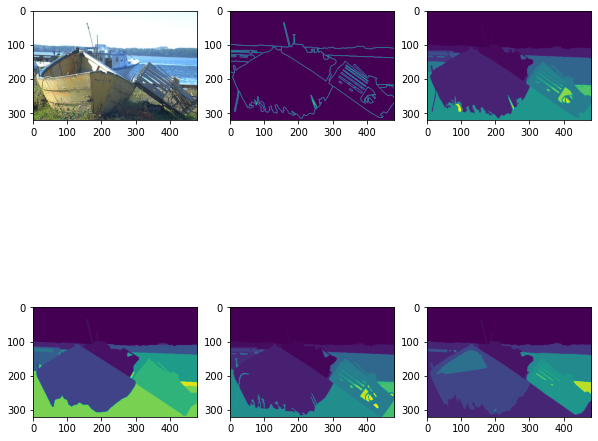

In [112]:
import random
def visualize_random():
    n = random.randint(0, 200)
    fig, axes = plt.subplots(2, 3)
    image = dataset["imgs"][n]
    if dataset["gt"][n][0].shape[0] != 321:
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    axes[0, 0].imshow(image)
    axes[0, 1].imshow(dataset["gt"][n][0])
    axes[0, 2].imshow(dataset["gt"][n][1][0])
    axes[1, 0].imshow(dataset["gt"][n][1][1])
    axes[1, 1].imshow(dataset["gt"][n][1][2])
    axes[1, 2].imshow(dataset["gt"][n][1][3])
    
    plt.show()
    
visualize_random()

In [113]:
def visualize_cluster(n, assignment):
    fig, axes = plt.subplots(2, 3)
    image = dataset["imgs"][n]
    if dataset["gt"][n][0].shape[0] != 321:
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    if assignment.shape[0] != 321:
        assignment = cv2.rotate(assignment, cv2.ROTATE_90_COUNTERCLOCKWISE)
    axes[0, 0].imshow(image)
    axes[0, 1].imshow(assignment)
    axes[0, 2].imshow(dataset["gt"][n][1][0])
    axes[1, 0].imshow(dataset["gt"][n][1][1])
    axes[1, 1].imshow(dataset["gt"][n][1][2])
    axes[1, 2].imshow(dataset["gt"][n][1][3])
    
    plt.show()


In [114]:
dataset['imgs'][0].shape

(321, 481, 3)

## 3. Segmentation using K-means (15 points)

Every image pixel is a feature vector of 3-dimension {R, G, B}. We will
use this feature representation to do the segmentation.

### 3. A. Kmeans Algorithm

We will change the K of the K-means algorithm between {3,5,7,9,11}
clusters. We will produce different segmentations and save them as
colored images. Every color represents a certain group (cluster) of
pixels.

#### Our implementation:

In [ ]:
class KMeans_imp:
    
    def __init__(self, n_clusters=3, max_iter=75, distribution='uniform'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.distribution = distribution

    def fit(self, data):
        '''
            Arguments:
                data: numpy array of shape [ h x w x 3 ]
        '''
        # Reshape x to be of shape [(hxw) x 3]
        X = np.reshape(data, (-1, 3))
        if self.distribution == 'random':
            # Get random initial centroids using choice
            self.centroids = np.array([random.choice(X) for _ in range(self.n_clusters)])
        elif self.distribution == 'uniform':
            min_, max_ = np.min(X, axis=0), np.max(X, axis=0)
            self.centroids = np.array([uniform(min_, max_) for _ in range(self.n_clusters)])
        old_centroids = [np.array([1000, 1000, 1000])+i for i in range(self.n_clusters)]
        t = 0
        # Start loop
        while not np.allclose(old_centroids, self.centroids) and t < self.max_iter:
            # Step 1: Cluster Assignment
            assignment = np.zeros((X.shape[0], 1))
            for i, x in enumerate(X): 
                dists = np.array([np.linalg.norm(x - c) for c in self.centroids])
                idx = np.argmin(dists)
                assignment[i, :] = idx
            old_centroids = self.centroids.copy()
            # Step 2: Centroid Update
            for i in range(self.n_clusters):
                assigned = X[np.where(assignment[:, 0]==i), :]
                self.centroids[i] = np.mean(assigned, axis=1)
            #Error checking if a centroid has no points
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():
                    self.centroids[i] = old_centroids[i]
            t+=1
        print("# of iterations", t)
        
    def predict(self, data):
        '''
            Arguments:
                data: numpy array of shape [ h x w x 3 ]
                
            Return values:
                clustered_data: numpy array of shape [ h x w x 1 ]
        '''
        X = np.reshape(data, (-1, 3))
        assignment = np.zeros((X.shape[0], 1))
        for i, x in enumerate(X): 
            dists = np.array([np.linalg.norm(x - c) for c in self.centroids])
            idx = np.argmin(dists)
            assignment[i, :] = idx
        assignment = np.reshape(assignment, (321, 481))
        return assignment

#### Testing our implementation:

In [ ]:
kmeans = KMeans_imp(3, 75)
kmeans.fit(dataset['imgs'][0])
indices = kmeans.predict(dataset['imgs'][0])

# of iterations 29


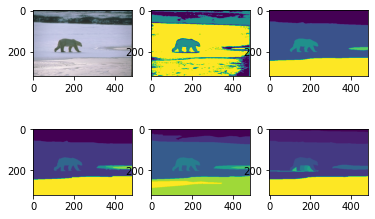

In [ ]:
visualize_cluster(0, indices)

#### Sklearn verification:

In [ ]:
from sklearn.cluster import KMeans

image = dataset["imgs"][0]
image = image.reshape((321*481, -1))
kmeans2 = KMeans(n_clusters=3, random_state=0).fit(image)
indices2 = kmeans2.labels_
indices2 = np.reshape(indices2, (321, 481))

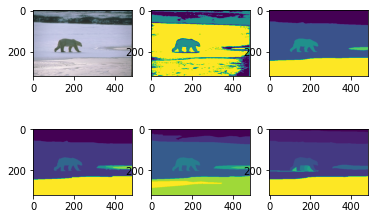

In [ ]:
visualize_cluster(0, indices2)

#### Changing K and showing results:

Our `results` dictionary is a dictionary mapping each value of K to a list containing 50 segmentation masks for 50 test photos. 

In [ ]:
results = {}
Ks = [3, 5, 7, 9, 11]

In [ ]:
for k in Ks:
    results[k] = []
    for i in range(50):
        image = dataset['imgs'][i]
        km = KMeans_imp(n_clusters=k, max_iter=75, distribution='uniform')
        km.fit(image)
        indices = km.predict(image)
        results[k].append(indices)

In [ ]:
# save results dictionary to file so we don't rerun every time
import pickle

dictionary = results
with open(base + 'saved_dictionary.pkl', 'wb') as f:
    pickle.dump(dictionary, f)
        
with open(base+ 'saved_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

#### Visualize a random result:

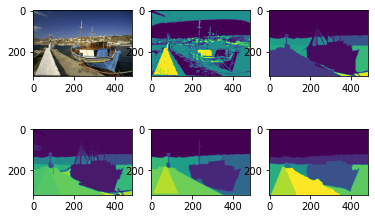

K= 3 n= 25


In [ ]:
k = random.choice(Ks)
n = random.randint(0, 50)
visualize_cluster(n, results[k][n])
print("K=", k, "n=", n)

### 3. B. Evaluation of Segmentation Results: Conditional Entropy and F-measure

We will evaluate the result segmentation using F-measure and Conditional Entropy for image I with M available ground-truth segmentations. For a clustering of K-clusters we report our
measures M times and the average of the M trials as well. We report average per dataset as well.

#### i. Conditional Entropy

Conditional entropy of clustering C:


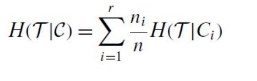


Conditional entropy with respect to cluster(i):

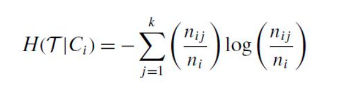




In [ ]:
# First, we do max-matching to match clusters with each other:

def max_matching(gt, indices):
    pass

In [ ]:
from math import log10 as log

from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support



def conditional_entropy(cluster_labels, gt):
    
    gt_labels = gt.flatten() # 154401 x 1

    contingency_mat = contingency_matrix (gt_labels,cluster_labels)
    contingency_T = contingency_mat.T
    
    count_cluster = np.sum(contingency_T, axis =1)
    
    count_entropy = np.where(np.copy(contingency_T) == 0, 1, np.copy(contingency_T)) ## where log(1) = 0 && log(0) = -infinty
    entropy_mat = np.zeros((count_entropy.shape[0],1))
    
    for i in range(count_entropy.shape[0]):
        entropy_mat[i] = np.sum(-contingency_T[i]*np.log10(count_entropy[i]/np.sum(contingency_T[i]))) / np.sum(contingency_T[i]) ## H(T|Ci)
        entropy_mat[i] = count_cluster[i] * entropy_mat[i] ## segma i = 1 till number of clusters : counter per cluster * H(T|Ci)
   
    entropy = np.sum(entropy_mat)/ np.sum(count_cluster) ## final conditional entropy
    
    return entropy

def f_measure(img_labels,gt):
    gt_labels = gt.flatten() # 154401 x 1
    _, _, fscore, _ = precision_recall_fscore_support(gt_labels, img_labels)
    return np.mean(fscore)
    


# for each K there is a corresponding conditional entropy value 
# where we are going to take the average of the conditional entropy 
# of the 50 images that we are testing.

 # for each k there exists 50 images where each image has 5 conditional entropy
conditional_entropies = {}
f_measures = {}
# k -> image index -> 5 (ground truth variations) -> conditional entropy
# (#_ofKs) 5 * (#_ofImages) 50 * (Without Edges) 4  

# for each k there exists 50 images where each image has an avg conditional entropy
# TLDR: avg of conditional_entropies for each image 
avg_conditional_entropies = {}
avg_fmeasures = {}
# (#_ofKs) 5 * (#_ofImages) 50

for k in labels.keys():
    # for each results[k] there exists 50 images
    k_image_avg_conditional_entropy = []
    k_image_conditional_entropy = {}
    
    k_image_avg_fmeasure = []
    k_image_fmeasure = {}
    
    for j, img in enumerate(labels[k]):
        m_conditional_entropies = []
        m_fmeasures = []
        # for each image we want to calculate the conditional entropy 
        # and then using all of the available ground truth of size M (= 5)
        # and then taking the average of the conditional entropies 
        # resulted from the 5 versions of ground turths existing for each image
        
        image_avg_entropy = 0
        image_avg_fmeasure = 0
        
        # dataset['gt]' 
        # 0 -> edges
        # 1, 2, 3, 4 -> actual ground_truth
        for gt_v in [1,2,3,4]:
            image_entropy = conditional_entropy(img, dataset['gt'][j][gt_v])
            image_avg_entropy += image_entropy
            m_conditional_entropies.append(image_entropy)
            
            
            image_fmeasure = f_measure(img, dataset['gt'][j][gt_v])
            #TODO: F-Measure
#             image_avg_fmeasure += image_fmeasure
            image_avg_fmeasure += 0
            m_fmeasures.append(image_fmeasure)
            
            # for each gt version find the conditional entorpy
        image_avg_entropy /= 4  # len([1,2,3,4]) # finding avg
        image_avg_fmeasure /= 4
        
        k_image_conditional_entropy[j] = m_conditional_entropies
        k_image_avg_conditional_entropy.append(image_avg_entropy)
        
        k_image_fmeasure[j] = m_fmeasures
        k_image_avg_fmeasure.append(image_avg_fmeasure)
        
        
    conditional_entropies[k] = k_image_conditional_entropy
    avg_conditional_entropies[k] = k_image_avg_conditional_entropy
    
    f_measures[k] = k_image_fmeasure
    avg_fmeasures[k] = k_image_avg_fmeasure
            


In [ ]:
len(avg_conditional_entropies[11])

In [ ]:
len(conditional_entropies[11][0])

### 3. C. Display Results

In this section, we display good results and bad results for every configuration in a, b and we discuss them.

## 4. Big Picture (10 Points)

### 4. A. Comparing GT vs. Segmentation Results (KMeans)

Here, we select a set of five images and display their corresponding groundtruth against our segmentation results using K-means at K=5. Comment on the results.

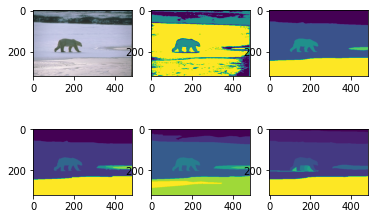

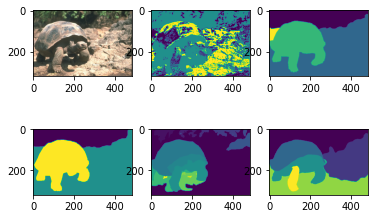

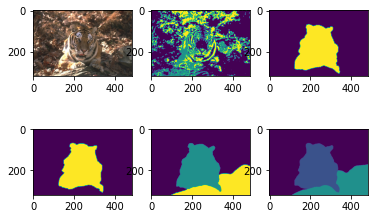

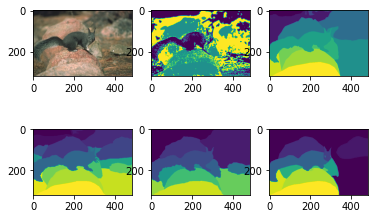

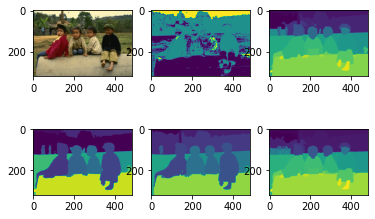

In [ ]:
selected_images = [0,7,20,30,47]
seg_res_knn = []

for img_idx in selected_images:
    segmented_img = results[5][img_idx]
    seg_res_knn.append(segmented_img)
    fig, axes = plt.subplots(2, 3)
    axes[0, 0].imshow(dataset["imgs"][img_idx])
    axes[0, 1].imshow(segmented_img)
    axes[0, 2].imshow(dataset["gt"][img_idx][1][0])
    axes[1, 0].imshow(dataset["gt"][img_idx][1][1])
    axes[1, 1].imshow(dataset["gt"][img_idx][1][2])
    axes[1, 2].imshow(dataset["gt"][img_idx][1][3])   
plt.show()
    

### 4. B. Comparing GT vs. Segmentation Results (N-Cut)

Here, we select the same five images and display their corresponding groundtruth against our segmentation results using Normalized-cut for the 5-NN graph, at K=5.

In [ ]:
!pip install pyamg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 6.4 MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


Done fitting!


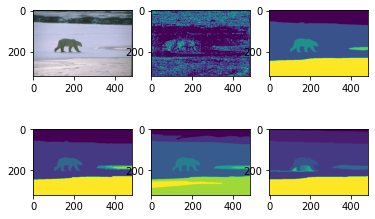

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


Done fitting!


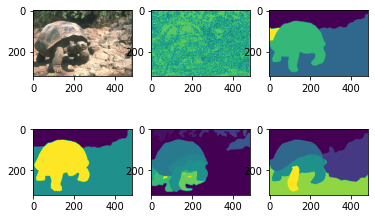

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


Done fitting!


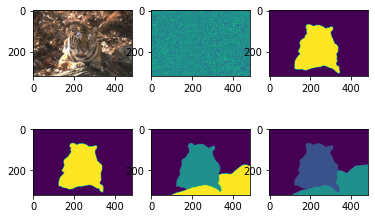

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


Done fitting!


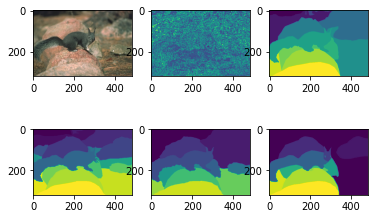

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


Done fitting!


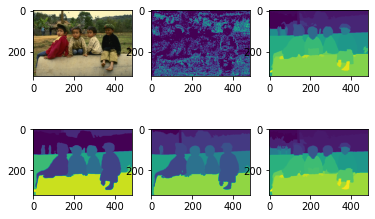

In [ ]:
from sklearn.cluster import SpectralClustering

selected_images = [0,7,20,30,47]

seg_res_spectral = []

for img_idx in selected_images:
    image = dataset["imgs"][img_idx]
    X = np.reshape(image, (321*481, -1))
    spectral = SpectralClustering(n_clusters=5, eigen_solver='amg', n_init=30, random_state=5, affinity='nearest_neighbors', n_neighbors=5, n_jobs=-1)
    indices = spectral.fit_predict(X)
    indices = np.reshape(indices, (321, 481))
    print("Done fitting!")
    seg_res_spectral.append(indices)
    
    fig, axes = plt.subplots(2, 3)
    axes[0, 0].imshow(image)
    axes[0, 1].imshow(indices)
    axes[0, 2].imshow(dataset["gt"][img_idx][1][0])
    axes[1, 0].imshow(dataset["gt"][img_idx][1][1])
    axes[1, 1].imshow(dataset["gt"][img_idx][1][2])
    axes[1, 2].imshow(dataset["gt"][img_idx][1][3])
    
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


Done fitting!


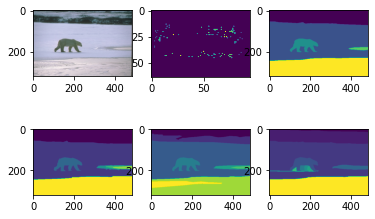

Done fitting!


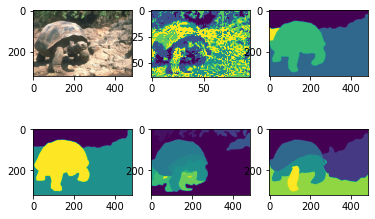

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


Done fitting!


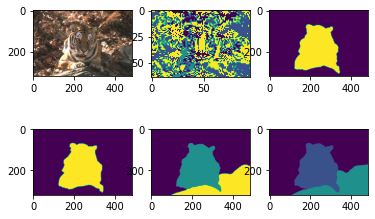

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


Done fitting!


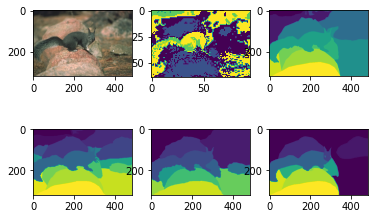

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


Done fitting!


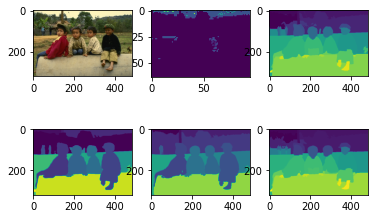

In [ ]:
# with resizing

from sklearn.cluster import SpectralClustering

selected_images = [0,7,20,30,47]

seg_res_spectral_2 = []

for img_idx in selected_images:
    image = dataset["imgs"][img_idx]
    image = np.array(image, dtype='uint8')
    r = image.shape[1] / image.shape[0]
    h = int(image.shape[0]/5)
    w = int(h * r )
    X = cv2.resize(image, (w, h), cv2.INTER_AREA)
    X = np.reshape(X, (X.shape[0]*X.shape[1], -1))
    spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', n_neighbors=5, n_jobs=-1)
    indices = spectral.fit_predict(X)
    indices = np.reshape(indices, (h, w))
    print("Done fitting!")
    seg_res_spectral_2.append(indices)
    
    fig, axes = plt.subplots(2, 3)
    axes[0, 0].imshow(image)
    axes[0, 1].imshow(indices)
    axes[0, 2].imshow(dataset["gt"][img_idx][1][0])
    axes[1, 0].imshow(dataset["gt"][img_idx][1][1])
    axes[1, 1].imshow(dataset["gt"][img_idx][1][2])
    axes[1, 2].imshow(dataset["gt"][img_idx][1][3])
    
    plt.show()

### 4. C. Comparing Results of K-means vs. Results of N-Cut

Here, we select the same five images and contrast our segmentation results using Normalized-cut for the 5-NN graph, at K=5 versus using K-means at K=5.

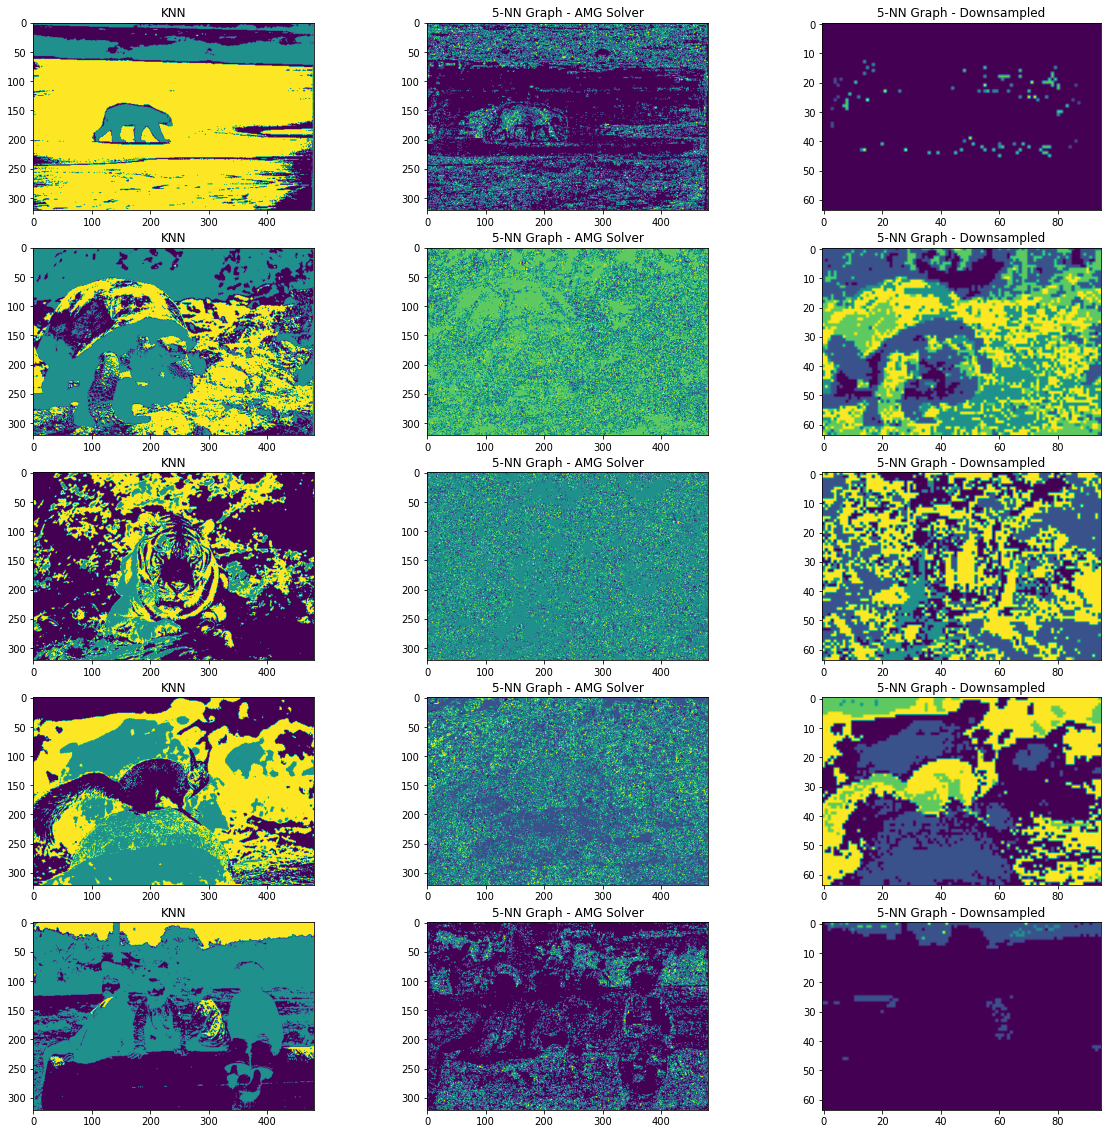

In [ ]:
fig, axes = plt.subplots(5, 3)
plt.rcParams['figure.figsize'] = 25, 25
for i in range(5):
        axes[i][0].imshow(seg_res_knn[i])
        axes[i][0].set_title("KNN")
        axes[i][1].imshow(seg_res_spectral[i])
        axes[i][1].set_title("5-NN Graph - AMG Solver")
        axes[i][2].imshow(seg_res_spectral_2[i])
        axes[i][2].set_title("5-NN Graph - Downsampled")
        
plt.show()

## 5. Extra (6 Points)


In the previous parts, we used the color features RGB. We did not
encode the layout of the pixels. We want to modify that for K-means
clustering to encode the spatial layout of the pixels.

#### Kmeans Modified: 

**i. Suggestion of a way to modify the feature vector to include spatial
layout:**

Our idea is to add two extra elements to our feature vector, `x_pos` and `y_pos` as a way to positionally and spatially encode our image, in such a way that items that are closer together on the x axis or the y axis or both are more similar than items that are further away.

This way, our feature vector's shape becomes `(1, 5)` instead of the original `(1, 3)` feature vector encoding only the RGB channels.

In [115]:
class KMeans_modified:
    
    def __init__(self, n_clusters=3, max_iter=75, distribution='uniform'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.distribution = distribution

    def encode(self, data):
        # encodes x and y coordinates
        img = np.float32(data)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        yx_coords = np.column_stack(np.where(gray >= 0))
        img2 = np.reshape(img, (-1, 3))
        new_data = np.concatenate((img2, yx_coords), axis=1)
        return new_data

    def fit(self, data):
        '''
            Arguments:
                data: numpy array of shape [ h x w x 3 ]
        '''
        # Reshape x to be of shape [(hxw) x 3]
        X = self.encode(data)
        assert X.shape[1] == 5
        if self.distribution == 'random':
            # Get random initial centroids using choice
            self.centroids = np.array([random.choice(X) for _ in range(self.n_clusters)])
        elif self.distribution == 'uniform':
            min_, max_ = np.min(X, axis=0), np.max(X, axis=0)
            self.centroids = np.array([uniform(min_, max_) for _ in range(self.n_clusters)])
        old_centroids = [np.array([1000, 1000, 1000, 1000, 1000])+i for i in range(self.n_clusters)]
        t = 0
        # Start loop
        while not np.allclose(old_centroids, self.centroids) and t < self.max_iter:
            # Step 1: Cluster Assignment
            assignment = np.zeros((X.shape[0], 1))
            for i, x in enumerate(X): 
                dists = np.array([np.linalg.norm(x - c) for c in self.centroids])
                idx = np.argmin(dists)
                assignment[i, :] = idx
            old_centroids = self.centroids.copy()
            # Step 2: Centroid Update
            for i in range(self.n_clusters):
                assigned = X[np.where(assignment[:, 0]==i), :]
                self.centroids[i] = np.mean(assigned, axis=1)
            #Error checking if a centroid has no points
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():
                    self.centroids[i] = old_centroids[i]
            t+=1
        print("# of iterations", t)
        
    def predict(self, data):
        '''
            Arguments:
                data: numpy array of shape [ h x w x 3 ]
                
            Return values:
                clustered_data: numpy array of shape [ h x w x 1 ]
        '''
        X = self.encode(data)
        assignment = np.zeros((X.shape[0], 1))
        for i, x in enumerate(X): 
            dists = np.array([np.linalg.norm(x - c) for c in self.centroids])
            idx = np.argmin(dists)
            assignment[i, :] = idx
        assignment = np.reshape(assignment, (321, 481))
        return assignment

In [118]:
seg_res_modified = []

for img_idx in selected_images:
    image = dataset["imgs"][img_idx]
    km = KMeans_modified(n_clusters=5, max_iter=75, distribution='uniform')
    km.fit(image)
    indices = km.predict(image)
    seg_res_modified.append(indices)

# of iterations 39
# of iterations 39
# of iterations 65
# of iterations 40
# of iterations 60


**ii. Contrasting the results we obtained in 4.a to the results we obtained by considering the spatial layout:**

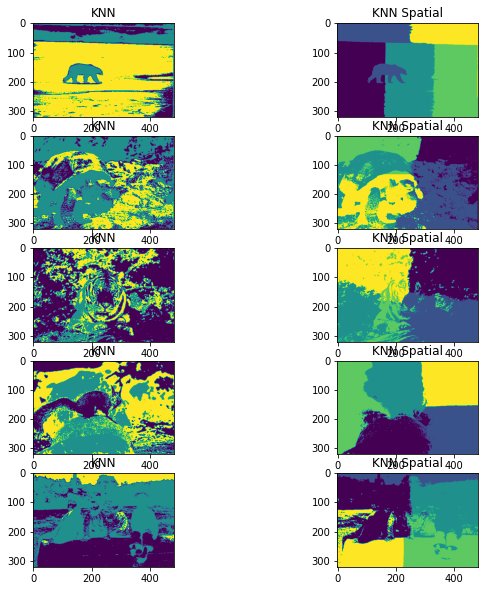

In [121]:
fig, axes = plt.subplots(5, 2)
plt.rcParams['figure.figsize'] = 15, 15
for i in range(5):
        axes[i][0].imshow(seg_res_knn[i])
        axes[i][0].set_title("KNN")
        axes[i][1].imshow(seg_res_modified[i])
        axes[i][1].set_title("KNN Spatial")
        
plt.show()